# House Price Prediction Using JAX (Flax & Optax)

This notebook builds a neural network using JAX with Flax and Optax to predict house prices. It follows the same workflow as the Keras/TensorFlow version:

- Load and preprocess the data (fill missing values, one-hot encode categorical variables).
- Split `train.csv` into 80% training and 20% validation and scale features.
- Build a neural network with two hidden layers (128 and 64 nodes) and dropout.
- Train the model using a mean squared error loss and the Adam optimizer.
- Evaluate using RMSE on the validation set.
- Process `test.csv` with the final model and save predictions to a CSV file with columns **ID** and **SALEPRICE**.

There is no single answer for the number of nodes—you can start with 128 and 64 as a baseline and later tune these hyperparameters.

In [2]:
pip install jax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 51.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install flax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.3 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
np.random.seed(42)
jax.config.update("jax_platform_name", "cpu")  # Change to 'gpu' if available

print('JAX version:', jax.__version__)

JAX version: 0.5.0


## 1. Load the Data

Replace the placeholder paths with your actual file paths for `train.csv` and `test.csv`.

In [6]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

### 2.1 Handling Missing Values and Encoding

We fill missing values (numeric with the median, categorical with the mode) and then convert categorical variables to dummy/one-hot variables. In the training data we drop the `Id` column and separate out `SalePrice` as the target.

In [7]:
def fill_missing_values(df):
    # Fill numeric columns with the median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with the mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_7827/2440015974.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_7827/2440015974.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

### 2.2 Train-Validation Split and Scaling

We split the training data (80% train, 20% validation) and scale the features using `StandardScaler`.

In [8]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 230)
X_val_scaled shape: (200, 230)


## 3. Convert Data to JAX Arrays

We now convert our numpy arrays to JAX arrays. Since the dataset is small, we will use full-batch training here (or you can later build a mini-batch data loader).

In [9]:
X_train_jax = jnp.array(X_train_scaled)
y_train_jax = jnp.array(y_train.values).reshape(-1, 1)

X_val_jax = jnp.array(X_val_scaled)
y_val_jax = jnp.array(y_val.values).reshape(-1, 1)

print('X_train_jax shape:', X_train_jax.shape)
print('X_val_jax shape:', X_val_jax.shape)

X_train_jax shape: (800, 230)
X_val_jax shape: (200, 230)


## 4. Define the JAX Model Using Flax

We define a neural network with two hidden layers (128 nodes then 64 nodes) and dropout. The dropout rate is 0.2. Note that during evaluation we set dropout to be deterministic.

In [10]:
class HousePriceNet(nn.Module):
    dropout_rate: float = 0.2
    
    @nn.compact
    def __call__(self, x, training):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn.Dense(1)(x)
        return x

# Initialize the model
model = HousePriceNet()

# Create a PRNG key
rng = jax.random.PRNGKey(0)

# Initialize model parameters (using a dummy input with the correct shape)
dummy_input = jnp.ones((X_train_jax.shape[0], X_train_jax.shape[1]))
params = model.init(rng, dummy_input, training=True)['params']

print('Model parameters initialized.')

Model parameters initialized.


## 5. Define the Training State and Loss Function

We use Optax's Adam optimizer and create a training state to hold the model parameters and optimizer state. We define a simple mean squared error (MSE) loss.

In [11]:
class TrainState(train_state.TrainState):
    pass

def mse_loss(params, batch, rng, training):
    inputs, targets = batch
    preds = model.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    loss = jnp.mean((preds - targets) ** 2)
    return loss

# Create the training state
learning_rate = 0.001
tx = optax.adam(learning_rate)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

print('Training state created.')

Training state created.


## 6. Define a Training Step and Evaluation Step

We define a `train_step` function that computes the gradient of the loss with respect to the parameters and updates the model. An `eval_step` computes the loss on the validation data.

In [12]:
@jax.jit
def train_step(state, batch, rng):
    grad_fn = jax.value_and_grad(mse_loss)
    loss, grads = grad_fn(state.params, batch, rng, True)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step(params, batch, rng):
    loss = mse_loss(params, batch, rng, False)
    return loss

# Function to compute RMSE
def compute_rmse(params, inputs, targets, rng):
    preds = model.apply({'params': params}, inputs, training=False, rngs={'dropout': rng})
    mse = jnp.mean((preds - targets) ** 2)
    return jnp.sqrt(mse)

## 7. Training Loop

We run the training loop for a set number of epochs. Here we use full-batch training (given the small dataset size). The training and validation losses are recorded each epoch.

In [13]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # For dropout, split rng for each step
    rng, step_rng = jax.random.split(rng)
    batch = (X_train_jax, y_train_jax)
    state, loss = train_step(state, batch, step_rng)
    train_losses.append(loss.item())
    
    # Evaluate on validation data
    val_loss = eval_step(state.params, (X_val_jax, y_val_jax), step_rng)
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        rmse = compute_rmse(state.params, X_val_jax, y_val_jax, step_rng)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse.item():.4f}")

Epoch 10/100 - Train Loss: 41067102208.0000, Val Loss: 34066671616.0000, Val RMSE: 184571.5938
Epoch 20/100 - Train Loss: 41065705472.0000, Val Loss: 34065455104.0000, Val RMSE: 184568.2969
Epoch 30/100 - Train Loss: 41063272448.0000, Val Loss: 34063245312.0000, Val RMSE: 184562.3125
Epoch 40/100 - Train Loss: 41058414592.0000, Val Loss: 34059298816.0000, Val RMSE: 184551.6094
Epoch 50/100 - Train Loss: 41050570752.0000, Val Loss: 34052675584.0000, Val RMSE: 184533.6719
Epoch 60/100 - Train Loss: 41037508608.0000, Val Loss: 34042171392.0000, Val RMSE: 184505.2031
Epoch 70/100 - Train Loss: 41018507264.0000, Val Loss: 34026424320.0000, Val RMSE: 184462.5312
Epoch 80/100 - Train Loss: 40989831168.0000, Val Loss: 34003939328.0000, Val RMSE: 184401.5781
Epoch 90/100 - Train Loss: 40954195968.0000, Val Loss: 33973217280.0000, Val RMSE: 184318.2500
Epoch 100/100 - Train Loss: 40901689344.0000, Val Loss: 33932646400.0000, Val RMSE: 184208.1562


## 8. Evaluate the Model on Validation Set

We compute the RMSE on the validation set.

In [14]:
val_rmse = compute_rmse(state.params, X_val_jax, y_val_jax, rng)
print('Final Validation RMSE:', val_rmse.item())

Final Validation RMSE: 184208.15625


## 9. Prepare Test Data and Make Predictions

We preprocess the test data in the same way as the training data: fill missing values, drop the `Id` column, one-hot encode, and align columns. The test features are then scaled, converted to a JAX array, and fed through the model to obtain predictions.

In [15]:
# Process test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)
test_jax = jnp.array(test_scaled)

# Predict on test data
preds_test = model.apply({'params': state.params}, test_jax, training=False, rngs={'dropout': rng})
preds_test = np.array(preds_test).flatten()

print('Test predictions shape:', preds_test.shape)

Test predictions shape: (460,)


/tmp/ipykernel_7827/2440015974.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_7827/2440015974.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 10. Save the Predictions

We save the predictions to a CSV file with the required columns: **ID** (integer) and **SALEPRICE** (float).

In [16]:
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': preds_test
})

# Replace with your desired output path
predictions_csv_path = 'predictions_jax.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_jax.csv


## 11. (Optional) Plot Training and Validation Loss

Plot the loss curves over the training epochs.

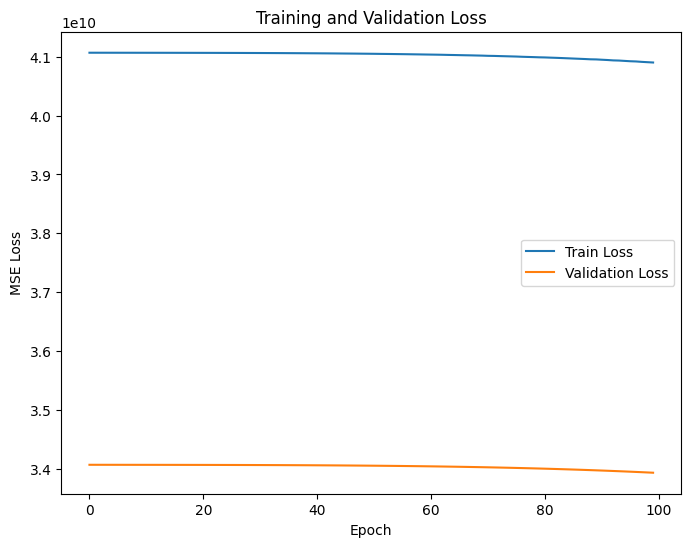

In [17]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()